In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from itertools import product
from scipy.stats import lognorm, norm
from sklearn.linear_model import LinearRegression 



DATA_DIR = Path('../data')
MODEL_DIR = Path('../models')

# Import Datasets

In [2]:
DATA_DIR = Path('../data')

X_train_file = DATA_DIR / 'X-train-from-distribution.npy'
Y_train_file = DATA_DIR / 'Y-train-from-distribution.npy'
X_train = np.load(X_train_file)
Y_train = np.load(Y_train_file)
print(f'Train dataset size: {X_train.shape}')

X_test_file = DATA_DIR / 'X-test-from-distribution.npy'
Y_test_file = DATA_DIR / 'Y-test-from-distribution.npy'
X_test = np.load(X_test_file)
Y_test = np.load(Y_test_file)
print(f'Test dataset size: {X_test.shape}')

Train dataset size: (18000, 15)
Test dataset size: (4500, 15)


In [3]:
lobes = np.array(["alpha'1", "alpha'2", "alpha'3", 'alpha1', 'alpha2', 'alpha3',
       "beta'1", "beta'2", 'beta1', 'beta2', 'gamma1', 'gamma2', 'gamma3',
       'gamma4', 'gamma5'])

greek_lobes = [
    r"$\alpha'_1$", r"$\alpha'_2$", r"$\alpha'_3$", 
    r'$\alpha_1$', r'$\alpha_2$', r'$\alpha_3$', 
    r"$\beta'_1$", r"$\beta'_2$",
    r'$\beta_1$', r'$\beta_2$', 
    r'$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$'
]

In [12]:
np.mean((Y_test - np.mean(Y_test))** 2)

0.0170388268905346

# Linear Fit (one-to-one)

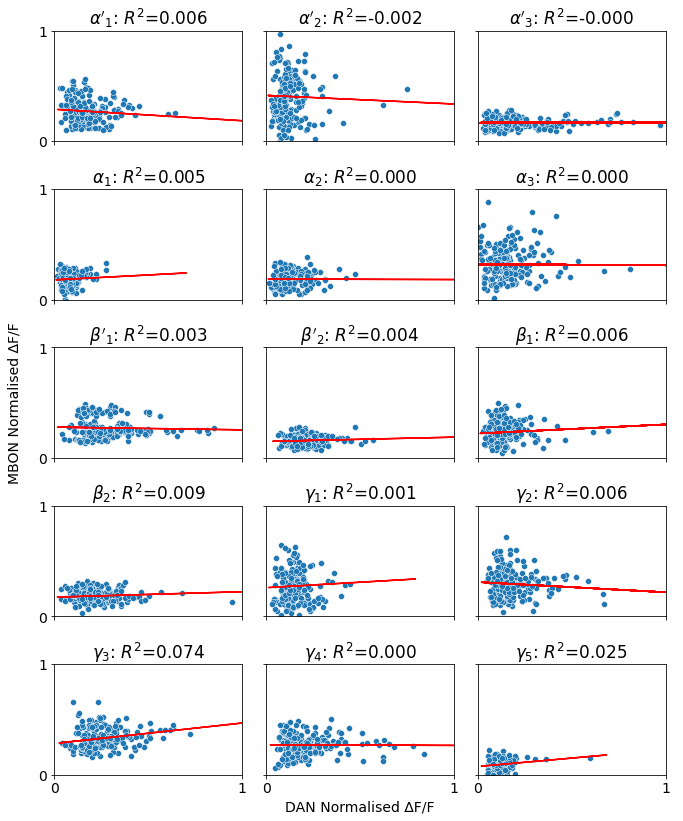

In [4]:
# use the testing data to find R^2 and mse
plt.rcParams["font.size"] = 14

model_parameters = {}
rsquared_canonical = {}
mse_canonical = {}

fig, axes = plt.subplots(5, 3, figsize=(10,12), sharex='all', sharey='all')

for i, lobe in enumerate(lobes):
    
    # fit canonical model  
    x = X_train[:, i]
    y = Y_train[:, i]
    xT = x.reshape((-1,1))
    model = LinearRegression(fit_intercept=True).fit(xT, y)
    
    # score using test set
    gt_x = X_test[:, i]
    gt_y = Y_test[:, i]
    gt_x = gt_x.reshape((-1,1))
    
    y_pred = model.predict(gt_x)
    
    score = model.score(gt_x, gt_y)
    rsquared_canonical[lobe] = score
    mse = np.sum((y_pred - gt_y)**2) / y_pred.size
    mse_canonical[lobe] = mse
    
    model_parameters[lobe] = {
        'm': model.coef_,
        'c': model.intercept_,
        'r2': score
    }
    
    ax = axes[int(i/3), i%3]
    ax.set_title(''.join([greek_lobes[i], r': $R^2$=', f'{score:.3f}']) )
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])

    ax.plot(xT, model.predict(xT), 'r')
    # downsample data for visualisation    
    sns.scatterplot(
        x = x[::90],
        y = y[::90],
        ax=ax
    )
    ax.set_xticks([])

    if i == 0:
        ax.set_yticks([0, 1])

ax.set_xticks([0, 1])

# Add common axis labels
fig.add_subplot(111, frameon=False)  
plt.grid(False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('DAN Normalised ∆F/F')
plt.ylabel('MBON Normalised ∆F/F')

plt.tight_layout()
plt.savefig('canonical-fit.png', transparent=True)

In [5]:
# Check that the Score is implemented using the standard R-squared algorithm

# total sum of squares: remove mean, square and sum
tss = np.sum((gt_y - gt_y.mean())**2)

# risidual sum of squares or the sum of residual errors
rss = np.sum((gt_y - y_pred)**2)

assert (1 - rss / tss) == score

In [6]:
gt_y.shape

(4500,)

In [7]:
tss

8.474253169590344

In [8]:
rss / y_pred.size

0.0018351913003480974

In [9]:
y_pred.size

4500

In [10]:
mse_canonical['gamma5']

0.0018351913003480974

In [11]:
def plot_matrix(matrix, labels, title, cbar_title=None, size=[8,8], switch=False):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(matrix)
    
    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(len(labels)), labels)
    plt.title(title)
    
    ax.set_ylim(14.5, -0.5)
    
    if switch:
        plt.xlabel('Target', fontsize=16)
        plt.ylabel('Source', fontsize=16)
    else:
        plt.xlabel('Source', fontsize=16)
        plt.ylabel('Target', fontsize=16)
    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            col = 'white' if matrix[i, j] < matrix.max()/2 else 'black'
            text = ax.text(j, i, int(matrix[i, j]),
                           ha="center", va="center", color=col)

    # Create colorbar
    if cbar_title is not None:
        cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel(cbar_title, rotation=-90, va="bottom", fontsize=16)

    plt.tight_layout()

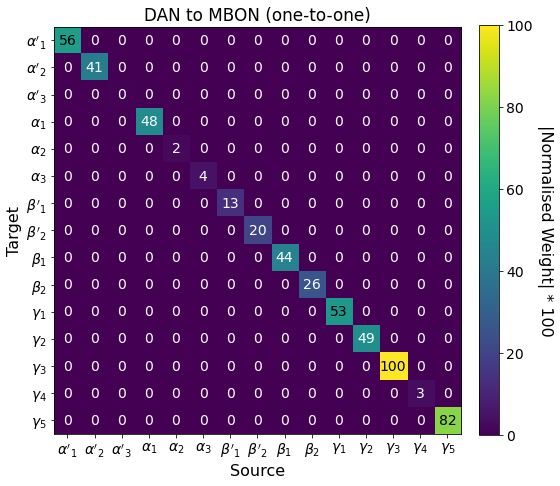

In [12]:

Wxh = np.zeros([15,15])
for i, lobe in enumerate(lobes):
    # weighting of connections for all DAN lobes to single MBON:lobe=lobe
    weight = model_parameters[lobe]['m']
    Wxh[i,i] = weight


M = np.abs(Wxh)
greek_lobes = [r"$\alpha '_1$", r"$\alpha '_2$", r"$\alpha '_3$", 
              r"$\alpha _1$", r"$\alpha _2$", r"$\alpha_3$",
              r"$\beta '_1$", r"$\beta '_2$", r"$\beta _1$", r"$\beta _2$",
              r"$\gamma _1$", r"$\gamma _2$", r"$\gamma _3$", r"$\gamma _4$", r"$\gamma _5$", ]

plot_matrix(
    M / M.max() * 100, 
    greek_lobes, 
    'DAN to MBON (one-to-one)', 
    '|Normalised Weight| * 100',
    switch=False
)

plt.savefig('weights-dan-to-mbon-canonical.png')

In [13]:
print(f'Mean score (R squared): {np.mean(list(rsquared_canonical.values()))}')

Mean score (R squared): 0.009303018155428222


In [14]:
print(f'Mean mse : {np.mean(list(mse_canonical.values()))}')

Mean mse : 0.010792468994111874


In [15]:
RESULTS_DIR = Path('../results')

file_name = 'canonical_linear_model_testing_data_rsquared.json'

with open( RESULTS_DIR / file_name, "w") as score_file:
    json.dump(rsquared_canonical, score_file, indent='\t')
    
file_name = 'canonical_linear_model_testing_data_mse.json'

with open( RESULTS_DIR / file_name, "w") as mse_file:
    json.dump(mse_canonical, mse_file, indent='\t')

## Linear Model (Cross Talk)

In [16]:
# Fit each of the lobes seperately
models = []
rsquared_crossed = {}
mse_crossed = {}

for i, lobe in enumerate(lobes):
    y = Y_train[:,i]
    gt_y = Y_test[:,i]
    model = LinearRegression(fit_intercept=True).fit(X_train, y)

    y_pred = model.predict(X_test)
    score = model.score(X_test, gt_y)
    print(f'score for {lobe}: {score}')
    mse = np.sum((y_pred - gt_y)**2) / y_pred.size

    models.append(model)
    rsquared_crossed[lobe] = score
    mse_crossed[lobe] = mse

print(f'Average score: {np.mean(list(rsquared_crossed.values()))}')

score for alpha'1: 0.07679824044407546
score for alpha'2: 0.09106954988155835
score for alpha'3: 0.08842705809607365
score for alpha1: 0.06038585335784141
score for alpha2: 0.07327519389664561
score for alpha3: 0.06780991177561935
score for beta'1: 0.154000707710099
score for beta'2: 0.03277431734251113
score for beta1: 0.07987667964470624
score for beta2: 0.04543464374457973
score for gamma1: 0.18304846710234834
score for gamma2: 0.08893957869682911
score for gamma3: 0.14543276842929587
score for gamma4: 0.20537375063024454
score for gamma5: 0.057378439503095846
Average score: 0.09666834401703489


In [17]:
# Check that the Score is implemented using the standard R-squared algorithm

# total sum of squares: remove mean, square and sum
tss = np.sum((gt_y - gt_y.mean())**2)

# risidual sum of squares or the sum of residual errors
rss = np.sum((gt_y - y_pred)**2)

assert (1 - rss / tss) == score

In [18]:
tss

8.474253169590344

In [19]:
rss / y_pred.size

0.0017751141659477971

In [20]:
y_pred.size

4500

In [22]:
mse_crossed['gamma5']

0.0017751141659477971

In [24]:
tss / y_pred.size

0.0018831673710200765

In [25]:
file_name = 'crossed_linear_model_testing_data_rsquared.json'

with open( RESULTS_DIR / file_name, "w") as score_file:
    json.dump(rsquared_crossed, score_file, indent='\t')

In [26]:
file_name = 'crossed_linear_model_testing_data_mse.json'

with open( RESULTS_DIR / file_name, "w") as mse_file:
    json.dump(mse_crossed, mse_file, indent='\t')

print(f'Mean mse : {np.mean(list(mse_crossed.values()))}')

Mean mse : 0.009709932272554412


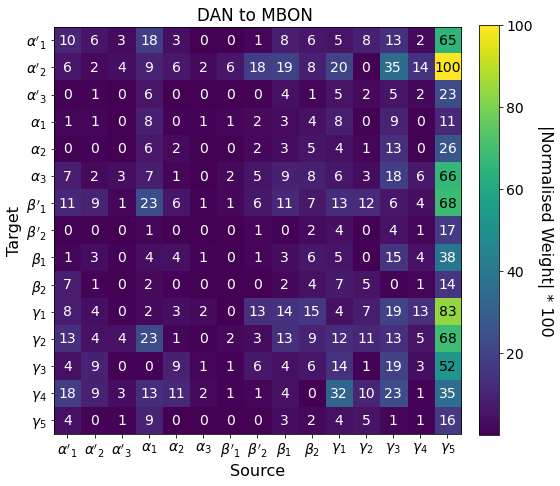

In [27]:
Wxh = np.zeros([15,15])
for i, lobe in enumerate(lobes):
    # weighting of connections for all DAN lobes to single MBON:lobe=lobe
    Wxh[i,:] = models[i].coef_

    
M = np.abs(Wxh)

plot_matrix(
    M / M.max() * 100, 
    greek_lobes, 
    'DAN to MBON ', 
    '|Normalised Weight| * 100',
    switch=False
)

plt.savefig('weights-dan-to-mbon-cross-talk.png') 

# Check R^2 values

In [28]:
with open( RESULTS_DIR / 'canonical_linear_model_testing_data_rsquared.json', "r") as score_file:
    score_canonical = json.load(score_file)

with open( RESULTS_DIR / 'crossed_linear_model_testing_data_rsquared.json', "r") as score_file:
    score_crossed = json.load(score_file)

In [29]:
score_df = pd.concat(
    [pd.Series(score_canonical, name='canonical score'), 
    pd.Series(score_crossed, name='crossed score') ],
    axis=1
)

# Basic stats
score_df.describe()

,canonical score,crossed score
count,15.000000,15.000000
mean,0.009303,0.096668
std,0.019015,0.051218
min,-0.001501,0.032774
25%,0.000299,0.064098
50%,0.004477,0.079877
75%,0.006286,0.118251
max,0.073847,0.205374


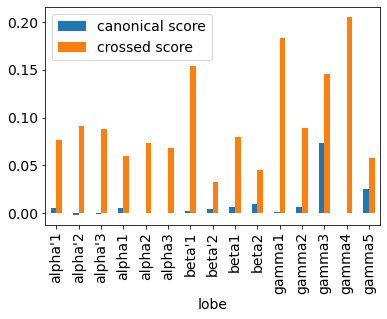

In [30]:
# Visual comparison

score_df["lobe"] = score_df.index
score_df.plot(x="lobe", y=["canonical score", "crossed score"], kind="bar")
plt.show()

# Compare MSE

In [31]:
RESULTS_DIR = Path('../results')

with open( RESULTS_DIR / 'canonical_linear_model_testing_data_mse.json', "r") as file:
    mse_canonical = json.load(file)

with open( RESULTS_DIR / 'crossed_linear_model_testing_data_mse.json', "r") as file:
    mse_crossed = json.load(file)
    
mse_df = pd.concat(
    [pd.Series(mse_canonical, name='canonical mse'), 
    pd.Series(mse_crossed, name='crossed mse') ],
    axis=1
)

mse_df.describe()

,canonical mse,crossed mse
count,15.000000,15.000000
mean,0.010792,0.009710
std,0.011766,0.010646
min,0.001796,0.001636
25%,0.003339,0.003185
50%,0.008031,0.006812
75%,0.014140,0.012193
max,0.047920,0.043491


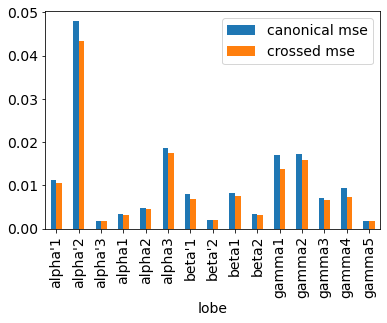

In [32]:
# Visual comparison

mse_df["lobe"] = mse_df.index
mse_df.plot(x="lobe", y=["canonical mse", "crossed mse"], kind="bar")
plt.show()